In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from linearmodels import IV2SLS
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from statsmodels.tools import add_constant
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import shutil
import re
import time
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
df_crime = pd.read_pickle('/scratch/kv942/Dejure/Notebooks/df_crime.pkl')
df_crime.head()

,original_path,act_path,Juridiction,year,file_name,Sections_302,Sections_304,Sections_304B,Sections_315,Sections_316,...,Sections_395,Sections_396,Sections_397,Sections_398,Sections_435,Sections_436,Sections_437,Sections_438,flag,Len
5451,/scratch/kv942/Dejure/delhi/2014/34613760.txt,/scratch/kv942/Dejure/delhi_1_crime/34613760.txt,delhi,2014,34613760,1,1,0,1,0,...,0,1,0,0,1,1,0,1,1,2056788
103133,/scratch/kv942/Dejure/allahabad/2017/37475462.txt,/scratch/kv942/Dejure/allahabad_crime/37475462...,allahabad,2017,37475462,1,1,0,1,1,...,0,0,0,0,1,0,1,0,1,1301263
7019,/scratch/kv942/Dejure/delhi/2015/154440315.txt,/scratch/kv942/Dejure/delhi_1_crime/154440315.txt,delhi,2015,154440315,1,1,0,1,1,...,1,1,1,0,0,1,1,1,1,1158189
11626,/scratch/kv942/Dejure/delhi/2017/127568675.txt,/scratch/kv942/Dejure/delhi_1_crime/127568675.txt,delhi,2017,127568675,1,1,0,1,0,...,1,1,1,1,1,1,1,1,1,1122351
3758,/scratch/kv942/Dejure/delhi/2013/170462018.txt,/scratch/kv942/Dejure/delhi_1_crime/170462018.txt,delhi,2013,170462018,0,0,0,0,0,...,1,0,1,0,0,1,1,1,1,902716


In [4]:
df_crime = df_crime.reset_index()

In [5]:
df_crime.shape

(39104, 42)

In [7]:
from bs4 import BeautifulSoup
import os
import pandas as pd
import datetime as dt

class extractMetadata():
    def __init__(self, fpath):
        with open(fpath, 'r') as f:
            self.soup = BeautifulSoup(f.read(), 'html.parser').find('div', attrs={'class':"judgments"})
        self.case_text = self.soup.text

    def null_check(self, soup_item, attr):
        if attr=='text':
            try:
                return soup_item.text
            except:
                return
        else:
            return soup_item.find(attr)


    def get_court(self):
        source = self.soup.find('div', attrs={'class':'docsource_main'})
        self.court = self.null_check(source, 'text')
        return self.court

    def get_pre(self):
        pre = self.soup.find('pre')
        self.pre = self.null_check(pre, 'text')
        return self.pre

    def get_title(self):
        title = self.null_check(self.soup.find_all('div', attrs={'class': 'doc_title'})[-1], 'text')
        self.title = title
        small_title, date = title.split(' on ')
        self.petitioner, self.respondent = small_title.split(' vs ')
        date = dt.datetime.strptime(date.strip(), '%d %B, %Y').date()
        self.date = dt.datetime.strftime(date, '%d-%m-%Y')
        return self.title

    def get_author(self):
        # NOTE: the author could be mentioned in the pretag when listing the CORAM
        author = self.null_check(self.soup.find('div', attrs={'class':'doc_author'}), 'text')
        if author:
            self.author = author.split('Author:')[-1]
        else:
            self.author = None
        return self.author

    def get_bench(self):
        bench = self.null_check(self.soup.find('div', attrs={'class':'doc_bench'}), 'text')
        if bench:
            self.bench = bench.split('Bench:')[-1]
        else:
            self.bench = None
        return self.bench

    def get_eq_citations(self):
        eq_citations = self.null_check(self.soup.find('div', attrs={'class':'doc_citations'}), 'text')
        if eq_citations:
            self.eq_citations = eq_citations.split('Equivalent citations:')[-1]
        else:
            self.eq_citations = None
        return self.eq_citations

    def get_jud_order(self):
        # make a guess about whether the document is a judgment or an order
        # 0 if ambiguous, 1 if judgment, -1 if order

        self.jud_order = 0
        if any([x in self.case_text for x in ['JUDGMENT', 'JUDGEMENT']]):
            self.jud_order += 1

        if 'ORDER' in self.case_text:
            self.jud_order+=1
        
        return self.jud_order

    def get_citations(self):
        # note: these citations are to both cases and statutes
        self.citations = [x['href'] for x in self.soup.find_all('a')]
        return self.citations

    def get_all_info(self):
        info = {}

        self.get_citations()
        self.get_jud_order()
        self.get_eq_citations()
        self.get_court()
        self.get_bench()
        self.get_author()
        self.get_title()
        self.get_pre()

        info['court'] = self.court
        info['author'] = self.author
        info['title'] = self.title
        info['petitioner'] = self.petitioner
        info['respondent'] = self.respondent
        info['doc_date'] = self.date
        #info['pre'] = self.pre
        info['citations'] = self.citations
        info['eq_citations'] = self.eq_citations
        info['judgment_order'] = self.jud_order
        return info



In [197]:
temp = pd.DataFrame(info_dict).T

In [201]:
temp = temp.reset_index()

In [202]:
temp.to_csv("/scratch/kv942/Dejure/Notebooks/case_info.csv",index=False)

In [193]:
info_dict ={}
for index,row in tqdm(df_crime.iterrows()):
    try:        
        case = extractMetadata(row.act_path)
        info = case.get_all_info()
        info_dict[row.file_name] = info
        
    except:
        continue


39104it [04:40, 139.52it/s]


In [203]:
temp.head()

,index,court,author,title,petitioner,respondent,doc_date,citations,eq_citations,judgment_order
0,34613760,Delhi High Court,Gita Mittal,"Vishal Yadav vs State Of U.P. on 2 April, 2014",Vishal Yadav,State Of U.P.,02-04-2014,"[/doc/118703205/, /doc/695990/, /doc/1560742/,...",None,0
1,37475462,Allahabad High Court,None,Swami Vasudevanand Saraswati ... vs Jagat Guru...,Swami Vasudevanand Saraswati ...,Jagat Guru Shankarcharya ...,22-09-2017,"[/doc/750643/, /doc/750643/, /doc/1671917/, /d...",None,0
2,154440315,Delhi High Court,Gita Mittal,Vishal Yadav vs State Govt. Of Up on 6 Februar...,Vishal Yadav,State Govt. Of Up,06-02-2015,"[/doc/1850315/, /doc/37788/, /doc/1560742/, /d...",None,0
3,127568675,Delhi High Court,None,"Sushil Arora vs State on 8 February, 2017",Sushil Arora,State,08-02-2017,"[/doc/137587/, /doc/1669125/, /doc/1934415/, /...",None,1
4,170462018,Delhi High Court,Gita Mittal,Delhi High Court Bar Association & ... vs Govt...,Delhi High Court Bar Association & ...,Govt. Of Nct Of Delhi & Anr.,09-10-2013,"[/doc/476269/, /doc/138097064/, /doc/138097064...",None,0


In [4]:
text_corpus = []
for file in tqdm(df_crime.act_path):

    text= open(file,'r').read()
    parsed_html = BeautifulSoup(text)
    text = parsed_html.body.find('div', attrs={'class':'judgments'}).text
    text_corpus.append(text)

100%|██████████| 39104/39104 [13:47<00:00, 47.28it/s]


In [5]:
text_corpus_df = pd.DataFrame(text_corpus,columns=['Text'])

In [9]:
#text_corpus_df.to_pickle('/scratch/kv942/Dejure/Notebooks/text_corpus_df.pkl')
#text_corpus_df.head()

,Text
0,Delhi High Court Vishal Yadav vs State Of U.P....
1,Allahabad High Court Swami Vasudevanand Sarasw...
2,Delhi High Court Vishal Yadav vs State Govt. O...
3,Delhi High Court Sushil Arora vs State on 8 Fe...
4,Delhi High Court Delhi High Court Bar Associat...


In [8]:
text_corpus_df = pd.read_pickle('/scratch/kv942/Dejure/Notebooks/text_corpus_df.pkl')

In [9]:
text_corpus_df['Text'] = [' '.join(x.split()) for x in text_corpus_df.Text]

In [10]:
text_corpus_df.head()

,Text
0,Delhi High Court Vishal Yadav vs State Of U.P....
1,Allahabad High Court Swami Vasudevanand Sarasw...
2,Delhi High Court Vishal Yadav vs State Govt. O...
3,Delhi High Court Sushil Arora vs State on 8 Fe...
4,Delhi High Court Delhi High Court Bar Associat...


In [11]:
temp = pd.concat([df_crime[['file_name','Juridiction']],text_corpus_df],axis=1)

In [162]:
temp.to_csv("text.csv",index=False)

In [3]:
df = pd.read_pickle("./violent_crimes.pkl")

In [5]:
f1 = pd.read_csv("flag1.csv")

In [6]:
f2 = pd.read_csv("Flag2.csv")

In [7]:
f2.columns = f1.columns

In [8]:
cases = pd.concat([f1,f2],axis =0)

In [9]:
#excluding one NAN in Case ID
cases = cases.sort_values(by='Case')[:600]

In [10]:
cases.set_index(['Case'],inplace=True)

In [11]:
df2 = pd.concat([df,cases],axis=1)
df2.head()

,original_path,act_path,Juridiction,year,file_name,Sections_302,Sections_304,Sections_304B,Sections_315,Sections_316,...,Sections_397,Sections_398,Sections_435,Sections_436,Sections_437,Sections_438,flag,Len,Text,lenient/harsh
0.0,/scratch/kv942/Dejure/delhi/2010/172888257.txt,/scratch/kv942/Dejure/delhi_1_crime/172888257.txt,delhi,2010,172888257,0,0,0,0,0,...,0,0,0,0,0,0,1,61742,"\nDelhi High Court\nRakesh vs State on 28 May,...",0.0
1.0,/scratch/kv942/Dejure/delhi/2017/158657439.txt,/scratch/kv942/Dejure/delhi_1_crime/158657439.txt,delhi,2017,158657439,0,0,0,0,0,...,0,0,0,0,0,0,1,110082,\nDelhi High Court\nDr. Shashi Tharoor vs Arna...,0.0
2.0,/scratch/kv942/Dejure/chattisgarh/2018/1936881...,/scratch/kv942/Dejure/chattisgarh_crime/193688...,chattisgarh,2018,193688153,1,0,0,0,0,...,1,0,0,0,0,0,1,62598,\nChattisgarh High Court\nAshok Kumar Mishra v...,0.0
3.0,/scratch/kv942/Dejure/delhi/2015/159727399.txt,/scratch/kv942/Dejure/delhi_1_crime/159727399.txt,delhi,2015,159727399,1,0,0,1,0,...,0,0,0,0,0,0,1,86906,\nDelhi High Court\nSwati vs Arvind Mudgal on ...,0.0
4.0,/scratch/kv942/Dejure/delhi/2017/190824458.txt,/scratch/kv942/Dejure/delhi_1_crime/190824458.txt,delhi,2017,190824458,1,0,0,0,0,...,0,0,0,0,1,0,1,64236,\nDelhi High Court\nUmesh Kumar vs State Nct O...,0.0


In [12]:
df2.columns = list(df2.columns[:-1])+list(["jud_flag"])
df2 = df2[df2.jud_flag.notna()]
df2['jud_flag'] = df2['jud_flag'].astype('int')

In [13]:
df2['Text'] = [' '.join(x.split()) for x in df2.Text]

In [18]:
import nltk
lst_stopwords = nltk.corpus.stopwords.words("english")
#lst_stopwords

In [20]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and  characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [21]:
# df2["text_clean"] = df2["Text"].apply(lambda x: 
#           utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
#           lst_stopwords=lst_stopwords))
# #df2.head()

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df2['Text'], df2['jud_flag'], test_size=0.2, random_state=0)
 

In [15]:
tfidf_vectorizer = TfidfVectorizer(stop_words={'english'})
tfidf_vectorizer.fit(X_train)


TfidfVectorizer(stop_words={'english'})

In [34]:
feature_array = np.array(tfidf_vectorizer.get_feature_names())
tfidf_sorting = np.argsort(X_test_tfidf.toarray()).flatten()[::-1]

n = 10
top_n = feature_array[tfidf_sorting][:n]

In [35]:
top_n

array(['the', 'of', 'and', '651', 'baiju', '251', 'to', 'that', 'in',
       'accused'], dtype='<U60')

In [16]:
X_train_tfidf = tfidf_vectorizer.transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Model
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

LogisticRegression()

In [17]:
print(f'Area under the ROC curve on the test data = {round(metrics.roc_auc_score(y_test, model.predict_proba(X_test_tfidf)[:,1]), 4)}')
print(f'Accuracy test data = {round(metrics.accuracy_score(y_test, model.predict(X_test_tfidf)), 4)}')


Area under the ROC curve on the test data = 0.6854
Accuracy test data = 0.575


In [18]:
model = BernoulliNB()
model.fit(X_train_tfidf, y_train)

BernoulliNB()

In [19]:
print(f'Area under the ROC curve on the test data = {round(metrics.roc_auc_score(y_test, model.predict_proba(X_test_tfidf)[:,1]), 4)}')
print(f'Accuracy test data = {round(metrics.accuracy_score(y_test, model.predict(X_test_tfidf)), 4)}')


Area under the ROC curve on the test data = 0.6834
Accuracy test data = 0.6


In [20]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=0)  
model.fit(X_train_tfidf, y_train)

RandomForestClassifier(random_state=0)

In [21]:
print(f'Area under the ROC curve on the test data = {round(metrics.roc_auc_score(y_test, model.predict_proba(X_test_tfidf)[:,1]), 4)}')
print(f'Accuracy test data = {round(metrics.accuracy_score(y_test, model.predict(X_test_tfidf)), 4)}')


Area under the ROC curve on the test data = 0.6768
Accuracy test data = 0.6167


In [23]:
import xgboost as xgb
model = xgb.XGBClassifier(
    learning_rate = 0.22,
    n_estimators = 50,
    reg_lambda = 0.01,
    reg_alpha = 0.1,
    #sub_sample = 0.8,
    seed = 50,
    objective = 'binary:logistic',
    max_depth=25,
    min_child_weight=30)
model.fit(X_train_tfidf, y_train)

[10:25:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.22, max_delta_step=0, max_depth=25,
              min_child_weight=30, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1, random_state=50,
              reg_alpha=0.1, reg_lambda=0.01, scale_pos_weight=1, seed=50,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [50]:
preds = np.where(model.predict_proba(X_test_tfidf)[:,1] > 0.5, 1, 0)

In [38]:
print(f'Area under the ROC curve on the test data = {round(metrics.roc_auc_score(y_test, model.predict_proba(X_test_tfidf)[:,1]), 4)}')
print(f'Accuracy test data = {round(metrics.accuracy_score(y_test, model.predict(X_test_tfidf)), 4)}')
print(f'F1 Score test data = {round(metrics.f1_score(y_test, model.predict(X_test_tfidf)), 4)}')


Area under the ROC curve on the test data = 0.8051
Accuracy test data = 0.7333
F1 Score test data = 0.619


In [53]:
print(metrics.classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.71      0.90      0.79        69
           1       0.79      0.51      0.62        51

    accuracy                           0.73       120
   macro avg       0.75      0.70      0.71       120
weighted avg       0.74      0.73      0.72       120



In [51]:
metrics.f1_score(y_test,preds)

0.6190476190476191

In [37]:
import pickle
pickle.dump(tfidf_vectorizer, open("tfidf1.pkl", "wb"))

In [41]:
import matplotlib.pyplot as plt

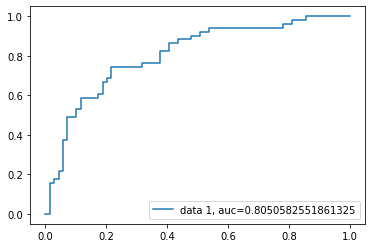

In [42]:
fpr, tpr, _ = metrics.roc_curve(y_test,  model.predict_proba(X_test_tfidf)[:,1])
auc = metrics.roc_auc_score(y_test, model.predict_proba(X_test_tfidf)[:,1])
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()


# Gensim Models

In [18]:
from gensim.models import Word2Vec
from gensim.parsing.preprocessing import remove_stopwords

from gensim.parsing.porter import PorterStemmer
porter_stemmer = PorterStemmer()
from gensim import corpora, models, similarities
import gensim

In [19]:
df2.head()

,original_path,act_path,Juridiction,year,file_name,Sections_302,Sections_304,Sections_304B,Sections_315,Sections_316,...,Sections_397,Sections_398,Sections_435,Sections_436,Sections_437,Sections_438,flag,Len,Text,jud_flag
0.0,/scratch/kv942/Dejure/delhi/2010/172888257.txt,/scratch/kv942/Dejure/delhi_1_crime/172888257.txt,delhi,2010,172888257,0,0,0,0,0,...,0,0,0,0,0,0,1,61742,"Delhi High Court Rakesh vs State on 28 May, 20...",0
1.0,/scratch/kv942/Dejure/delhi/2017/158657439.txt,/scratch/kv942/Dejure/delhi_1_crime/158657439.txt,delhi,2017,158657439,0,0,0,0,0,...,0,0,0,0,0,0,1,110082,Delhi High Court Dr. Shashi Tharoor vs Arnab G...,0
2.0,/scratch/kv942/Dejure/chattisgarh/2018/1936881...,/scratch/kv942/Dejure/chattisgarh_crime/193688...,chattisgarh,2018,193688153,1,0,0,0,0,...,1,0,0,0,0,0,1,62598,Chattisgarh High Court Ashok Kumar Mishra vs S...,0
3.0,/scratch/kv942/Dejure/delhi/2015/159727399.txt,/scratch/kv942/Dejure/delhi_1_crime/159727399.txt,delhi,2015,159727399,1,0,0,1,0,...,0,0,0,0,0,0,1,86906,Delhi High Court Swati vs Arvind Mudgal on 29 ...,0
4.0,/scratch/kv942/Dejure/delhi/2017/190824458.txt,/scratch/kv942/Dejure/delhi_1_crime/190824458.txt,delhi,2017,190824458,1,0,0,0,0,...,0,0,0,0,1,0,1,64236,Delhi High Court Umesh Kumar vs State Nct Of D...,0


In [28]:
def read_corpus(texts, tokens_only=False):
    
    for i, line in enumerate(texts):
        tokens = gensim.utils.simple_preprocess(line)
        if tokens_only:
            yield tokens
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

train_corpus = list(read_corpus(X_train))
test_corpus = list(read_corpus(X_test, tokens_only=True))


In [24]:
corpus = list(train_corpus)

In [38]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=60)

In [39]:
model.build_vocab(corpus)

In [40]:
print(f"Word 'penalty' appeared {model.wv.get_vecattr('penalty', 'count')} times in the training corpus.")

Word 'penalty' appeared 685 times in the training corpus.


In [41]:
model.train(corpus, total_examples=model.corpus_count, epochs=model.epochs)

In [28]:
from gensim.test.utils import get_tmpfile

fname = get_tmpfile("/scratch/kv942/Dejure/my_doc2vec_model")

In [29]:
model.save(fname)

In [23]:
model = gensim.models.doc2vec.Doc2Vec.load('/scratch/kv942/Dejure/my_doc2vec_model')

In [28]:
ranks = []
second_ranks = []
for doc_id in range(len(train_corpus[:5])):
    inferred_vector = model.infer_vector(train_corpus[doc_id].words)
    sims = model.dv.most_similar([inferred_vector], topn=len(model.dv))
    rank = [docid for docid, sim in sims].index(doc_id)
    ranks.append(rank)

    second_ranks.append(sims[1])

In [29]:
import collections

counter = collections.Counter(ranks)
print(counter)

Counter({1023: 1, 881: 1, 1448: 1, 4225: 1, 320: 1})


In [22]:
X_train[0]

'Delhi High Court Rakesh vs State on 28 May, 2010Author: Pradeep Nandrajog * IN THE HIGH COURT OF DELHI AT NEW DELHI % Judgment Reserved On: May 24, 2010 Judgment Delivered On: May 28, 2010 + CRL.APPEAL No.587/2008 RAKESH ..... Appellant Through: Mr.Sudershan Rajan, Advocate versus STATE ..... Respondent Through: Mr.M.N.Dudeja, Advocate CRL.APPEAL No.588/2008 RAJNEESH ..... Appellant Through: Mr.K.K.Sud, Senior Advocate with Mr.Kunal Malhotra and Mr.Ashish Das, Advocates versus STATE ..... Respondent Through: Mr.M.N.Dudeja, Advocate CRL.APPEAL No.1027/2008 LAL MOHAMMAD ..... Appellant Through: Mr.Bhupesh Narula, Advocate versus STATE ..... Respondent Through: Mr.M.N.Dudeja, Advocate CORAM: HON\'BLE MR. JUSTICE PRADEEP NANDRAJOG HON\'BLE MR. JUSTICE SURESH KAIT 1. Whether the Reporters of local papers may be allowed to see the judgment? 2. To be referred to the Reporter or not? 3. Whether the judgment should be reported in the Digest? PRADEEP NANDRAJOG, J. Crl.A.Nos.587/2008, 588/2008 &

In [37]:
model.docvecs[0]

array([ 0.5646442 , -2.5992346 , -0.05815776,  0.3274315 ,  1.4208007 ,
       -1.8943341 , -3.618582  , -2.034222  , -1.7488456 ,  0.56329185,
        3.5574992 ,  0.39721814,  0.9449101 ,  0.5164473 , -3.5023751 ,
        3.7700021 ,  1.2114936 ,  0.22689487,  0.9830784 , -1.3527882 ,
        1.451218  , -0.39223608, -0.7026509 ,  0.82619846,  0.4257404 ,
       -0.0438143 ,  2.8201907 , -2.9873667 , -1.5215774 , -2.7122416 ,
        2.1072848 ,  0.26088938,  0.21345818,  1.6717315 , -0.06933811,
        4.031834  , -0.24997051, -3.1603007 , -0.70234865, -0.05197067,
        0.38452938,  0.32595223,  1.550431  , -0.6657049 , -0.36018273,
        1.180123  ,  1.71784   , -3.6103935 ,  1.9566271 , -0.7678512 ],
      dtype=float32)

In [38]:
model.docvecs[1]

array([ 0.7936519 , -0.667344  , -4.993705  , -3.274565  ,  6.4008102 ,
       -1.9930494 , -3.0423315 , -4.168771  ,  2.00991   ,  3.0041711 ,
       -3.4352326 ,  5.793452  , -2.6655002 ,  7.5073695 , -2.1656098 ,
       -0.58859026,  3.7716396 ,  6.001111  ,  8.88924   , -8.507391  ,
       -0.08088927, -0.95811266, -1.0969253 ,  0.8036708 , -0.81239146,
       -0.2232343 , -1.5667877 , -1.1187072 , -1.903943  , -1.6598088 ,
        1.063276  , -4.0509853 ,  0.08777456,  1.2767138 , -2.3097098 ,
        2.7633848 , -0.5242196 , -8.916693  , -0.41054943, -6.7323785 ,
       -2.1042552 ,  5.883368  , -2.7243452 ,  1.736604  ,  4.040929  ,
        0.43003988,  3.4461567 ,  2.8299716 ,  0.38630265, -5.228234  ],
      dtype=float32)

In [40]:
doc_id = 23
inferred_vector = model.infer_vector(test_corpus[doc_id])
sims = model.dv.most_similar([inferred_vector], topn=10)

In [60]:
sims

[(1757, 0.9748429656028748),
 (1758, 0.9711358547210693),
 (3192, 0.8227819204330444),
 (3189, 0.7538601756095886),
 (3715, 0.7513518929481506),
 (4806, 0.748935878276825),
 (2702, 0.744621217250824),
 (1609, 0.729759931564331),
 (488, 0.7286121249198914),
 (775, 0.7266330718994141)]

In [28]:
inferred_vector = model.infer_vector(train_corpus[doc_id].words)

In [32]:
train_vectors = np.zeros((len(train_corpus),50))

In [33]:
for doc_id in tqdm(range(len(train_corpus))):
    train_vectors[doc_id,:] = model.infer_vector(train_corpus[doc_id].words)

100%|██████████| 477/477 [06:49<00:00,  1.17it/s]


In [34]:
test_vectors = np.zeros((len(test_corpus),50))

for doc_id in tqdm(range(len(test_corpus))):
    test_vectors[doc_id,:] = model.infer_vector(test_corpus[doc_id])

100%|██████████| 120/120 [01:38<00:00,  1.22it/s]


In [37]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier(
    learning_rate = 0.175,
    n_estimators = 100,
    reg_lambda = 0.01,
    reg_alpha = 0.1,
    #sub_sample = 0.8,
    seed = 60,
    objective = 'binary:logistic',
    max_depth=60,
    min_child_weight=10)

In [38]:
xgb_model.fit(train_vectors,y_train.values)

[14:56:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.175, max_delta_step=0, max_depth=60,
              min_child_weight=10, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=60,
              reg_alpha=0.1, reg_lambda=0.01, scale_pos_weight=1, seed=60,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [39]:
print(f'Area under the ROC curve on the test data = {round(metrics.roc_auc_score(y_test.values, xgb_model.predict_proba(test_vectors)[:,1]), 4)}')
print(f'Accuracy test data = {round(metrics.accuracy_score(y_test.values, xgb_model.predict(test_vectors)), 4)}')


Area under the ROC curve on the test data = 0.6394
Accuracy test data = 0.6167


In [40]:
import pickle
file_name = "xgb_harsh_lenient.pkl"

# save
pickle.dump(xgb_model, open(file_name, "wb"))

In [2]:
# Treatment Prediction on Complete Dataset
from gensim.models import Word2Vec
from gensim.parsing.preprocessing import remove_stopwords

from gensim.parsing.porter import PorterStemmer
porter_stemmer = PorterStemmer()
from gensim import corpora, models, similarities
import gensim

from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import shutil
import re
import time

model = gensim.models.doc2vec.Doc2Vec.load('/scratch/kv942/Dejure/my_doc2vec_model')

import pickle
file_name = "corpus.pkl"
test_corpus = pickle.load(open(file_name, "rb"))

test_corpus = test_corpus[:5000]

test_vectors = np.zeros((len(test_corpus),50))

for doc_id in tqdm(range(len(test_corpus))):
    test_vectors[doc_id,:] = model.infer_vector(test_corpus[doc_id])


pickle.dump(test_vectors,open('test_vectors_1.pkl','wb'))


100%|██████████| 5000/5000 [37:29<00:00,  2.22it/s] 


In [59]:
model_data = pd.read_pickle("model_data.pkl")

In [57]:
df2['harsh'] = model.predict(test_vectors)

In [60]:
df2['harsh'].value_counts()

0    23301
1     7751
Name: harsh, dtype: int64